In [ ]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

checkerboard_size = (10, 7)  # (nx, ny)
square_size = 0.02

objp = np.zeros((checkerboard_size[0] * checkerboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2)
objp *= square_size

objpoints = []
imgpoints = []

images = glob.glob('./iphone/images_1/*.jpg')
images = sorted(images)
new_size = (600, 600)

idx = 0
for fname in images:
    img = cv2.imread(fname)
    resized_img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
    gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

    if ret:
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1),
                                    criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        objpoints.append(objp)
        imgpoints.append(corners2)

        # cv2.drawChessboardCorners(resized_img, checkerboard_size, corners2, ret)
        # output_path = os.path.join(f"checked_image_{idx}.jpg")
        # cv2.imwrite(output_path, resized_img)
    else:
        print(fname)
    idx+=1

print(f"image_checked: {len(objpoints)}")


image_checked: 52


In [73]:
ret, mtx, dist, rot, trans = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

with open('iphone/K.txt', 'w') as f:
    for row in mtx:
        line = " ".join(map(str, row))
        f.write(line + "\n")
with open('iphone/D.txt', 'w') as f:
    for num in dist:
        line = " ".join(map(str, num))
        f.write(line + " ")

print("Intrinsic\n", mtx)
print("Distortion:\n", dist)

mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rot[i], trans[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    mean_error += error

print("Total Reprojection Error:", mean_error / len(objpoints))

with open('iphone/extrinsic_combined.txt', 'w') as f:
    for r, t in zip(rot, trans):
        rotation = [x[0] for x in r]
        line = " ".join(map(str, rotation))
        f.write(line+" ")
        translation = [x[0] for x in t]
        line = " ".join(map(str, translation))
        f.write(line + "\n")


Intrinsic
 [[599.4006603    0.         302.58489595]
 [  0.         604.96920167 315.97716578]
 [  0.           0.           1.        ]]
Distortion:
 [[ 0.18523149 -0.86506756 -0.00306752  0.00151666  1.43793462]]
Total Reprojection Error: 0.030956326575353965


In [74]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

from PIL import Image
from pose_vector_to_transformation_matrix import \
    pose_vector_to_transformation_matrix
from project_points import project_points
from undistort_image import undistort_image
from undistort_image_vectorized import undistort_image_vectorized

In [75]:
# load camera poses

# each row i of matrix 'poses' contains the transformations that transforms
# points expressed in the world frame to
# points expressed in the camera frame

pose_vectors = np.loadtxt('iphone/extrinsic_combined.txt')
# load camera intrinsics
K = np.loadtxt('iphone/K.txt')  # calibration matrix[3x3]
D = np.loadtxt('iphone/D.txt')  # distortion coefficients[2x1]

# load one image with a given index
img_index = 42

img = cv2.imread('iphone/images_1/iphone_12({0:02d}).jpg'.format(img_index + 5))
new_size = (600, 600)
img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

height, width, _ = img.shape

# project the corners on the image
# compute the 4x4 homogeneous transformation matrix that maps points
# from the world to the camera coordinate frame

T_C_W = pose_vector_to_transformation_matrix(pose_vectors[img_index-1, :])

In [76]:
# define 3D corner positions
# [Nx3] matrix containing the corners of the checkerboard as 3D points
# (X,Y,Z), expressed in the world coordinate system

square_size = 0.02  # [m]
num_corners_x = 10
num_corners_y = 7
num_corners = num_corners_x * num_corners_y

X, Y = np.meshgrid(np.arange(num_corners_x), np.arange(num_corners_y))
p_W_corners = square_size * np.stack([X, Y],
                                        axis=-1).reshape([num_corners, 2])

# add z coordinate, set z=0
p_W_corners = np.concatenate(
    [p_W_corners, np.zeros([num_corners, 1])], axis=-1)

(70, 3)


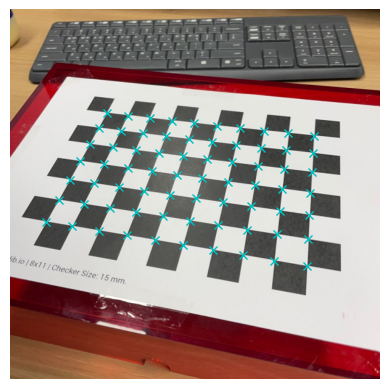

In [77]:
%matplotlib inline
D = np.loadtxt('iphone/D.txt')
# transform 3d points from world to current camera pose
p_C_corners = np.matmul(T_C_W[None, :, :],
                        np.concatenate([p_W_corners,
                                        np.ones([num_corners, 1])],
                                        axis=-1)[:, :, None]).squeeze(-1)

p_C_corners = p_C_corners[:, :3]
print(p_C_corners.shape)
#imgpoints2, _ = cv2.projectPoints(p_W_corners, pose_vectors[:3], pose_vectors[3:], K, D)
projected_pts = project_points(p_C_corners, K, D)

plt.imshow(img)
plt.plot(projected_pts[:, 0], projected_pts[:, 1], 'cx')
plt.axis('off')
plt.show()

In [79]:
# Re-generate img_undistored
img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)

In [53]:
offset_x = 0.02 * 1
offset_y = 0.02
s = 2 * 0.02

X, Y, Z = np.meshgrid(np.arange(2), np.arange(2), np.arange(-1, 1))
p_W_cube = np.stack([
    offset_x + X.flatten()*s,
    offset_y + Y.flatten()*s,
    Z.flatten()*s,
    np.ones([8])], axis=-1)
p_W_cube = p_W_cube.reshape(8, 1, 4)

vertex_id = (
    0, 2, 6, 4, # base layer of the cube
    1, 3, 7, 5, # top layer of the cube
)

lines_id = (
    [0, 1], [2, 3], [4, 5], [6, 7], # vertical lines
    [0, 2], [2, 6], [6, 4], [4, 0], # base lines
    [1, 3], [3, 7], [7, 5], [5, 1], # top lines
)

# set points in world coordinate
num_pts_per_line = 50
weights = np.linspace(0, 1, num_pts_per_line)[..., None]
p_W_cube_all = np.zeros((num_pts_per_line * 12, 4))
for ii, line in enumerate(lines_id):
    indices = slice(ii * num_pts_per_line, (ii + 1) * num_pts_per_line)
    p_W_cube_all[indices] = (weights * p_W_cube[line[0]] + (1 - weights) * p_W_cube[line[1]]).reshape(-1, 4)

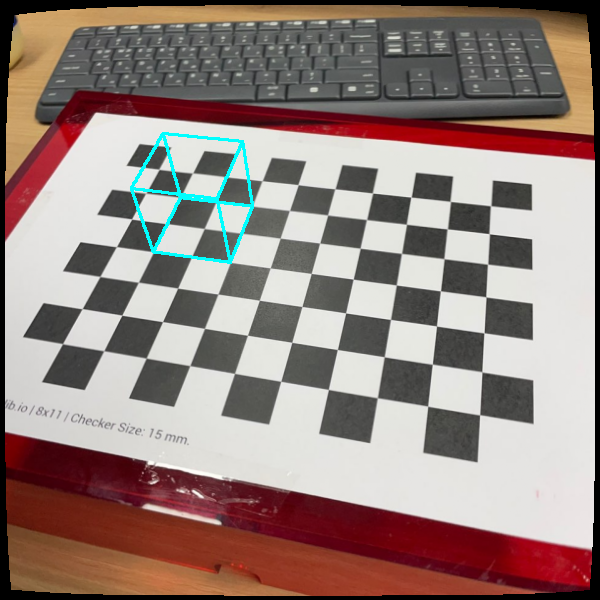

In [ ]:
# project on image coordinate
p_C_cube = np.matmul(T_C_W[None, :, :], p_W_cube_all[:, :, None]).squeeze(-1)
p_C_cube = p_C_cube[:, :3]

cube_pts = project_points(p_C_cube, K, np.zeros([5, 1]))
cube_pts_int = cube_pts.astype(int)
cube_pts_int = np.unique(cube_pts_int, axis=0)

# draw points
for x, y in cube_pts_int:
    for iy in range(-1, 2):
        for ix in range(-1, 2):
            img_undistorted[y+iy, x+ix] = (0, 255, 255)

Image.fromarray(img_undistorted)

In [55]:
# calculate the cube points to then draw the image
offset_x = 0.02 * 1
offset_y = 0.02
s = 2 * 0.02

X, Y, Z = np.meshgrid(np.arange(2), np.arange(2), np.arange(-1, 1))
p_W_cube = np.stack([
    offset_x + X.flatten() * s,
    offset_y + Y.flatten() * s,
    Z.flatten() * s,
    np.ones([8])], axis=-1)
p_W_cube = p_W_cube.reshape(8, 1, 4)

vertex_id = (
    0, 2, 6, 4, # base layer of the cube
    1, 3, 7, 5, # top layer of the cube
)

lines_id = (
    [0, 1], [2, 3], [4, 5], [6, 7], # vertical lines
    [0, 2], [2, 6], [6, 4], [4, 0], # base lines
    [1, 3], [3, 7], [7, 5], [5, 1], # top lines
)

# set points in world coordinate
num_pts_per_line = 50
weights = np.linspace(0, 1, num_pts_per_line)[..., None]
p_W_cube_all = np.zeros((num_pts_per_line * 12, 4))
for ii, line in enumerate(lines_id):
    indices = slice(ii * num_pts_per_line, (ii + 1) * num_pts_per_line)
    p_W_cube_all[indices] = (weights * p_W_cube[line[0]] + (1 - weights) * p_W_cube[line[1]]).reshape(-1, 4)


In [62]:
s = 0.04 * 1
start = 0.08
end = 0.24

sakabam = cv2.imread('./data/sakabam_gray.jpg') #200 200 3
sakabam = cv2.cvtColor(sakabam, cv2.COLOR_BGR2RGB)
sakabam = np.flip(sakabam, axis=0)

x = np.linspace(0, 0.04, 200)
z = np.linspace(0, 0.04, 200)

X, Z = np.meshgrid(x, z)
p_W_saka_1 = np.stack([X, np.ones_like(X)*0.02, -Z, np.ones_like(X)]).reshape(4, -1).T

x = np.linspace(0.06, 0.10, 200)
z = np.linspace(0.04, 0.08, 200)

X, Z = np.meshgrid(x, z)
p_W_saka_2 = np.stack([X, np.ones_like(X)*0.02*4, -Z, np.ones_like(X)]).reshape(4, -1).T

x = np.linspace(0.12, 0.16, 200)
z = np.linspace(0.02, 0.06, 200)

X, Z = np.meshgrid(x, z)
p_W_saka_3 = np.stack([X, np.ones_like(X)*0.02*2, -Z, np.ones_like(X)]).reshape(4, -1).T

  0%|          | 0/52 [00:00<?, ?it/s]

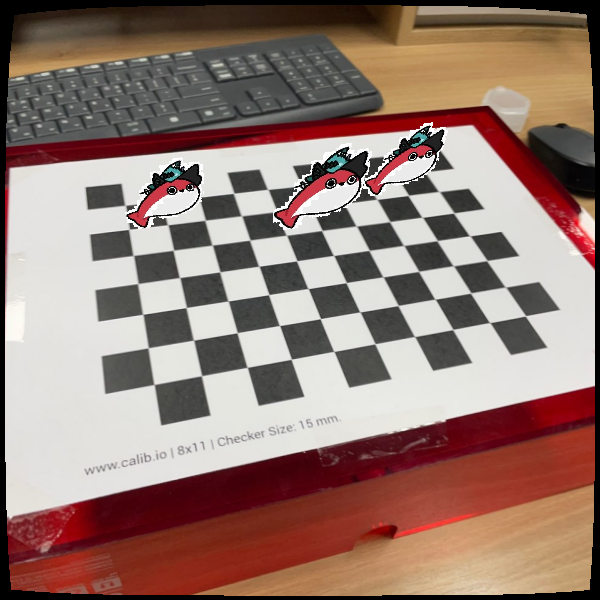

In [ ]:
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import glob
images = []


images_name = glob.glob('./iphone/images_1/*.jpg')
images_name = sorted(images_name)
new_size = (600, 600)
for ii in tqdm(range(len(images_name))):
    img_index = ii + 1
    img = cv2.imread(images_name[ii])
    img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # undistort image with bilinear interpolation
    img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)

    # project the corners on the image
    # compute the 4x4 homogeneous transformation matrix that maps points
    # from the world to the camera coordinate frame

    T_C_W = pose_vector_to_transformation_matrix(pose_vectors[ii, :])
    ######################################################################################
    # ## Draw Cube
    # # project on image coordinate
    # p_C_cube = np.matmul(T_C_W[None, :, :], p_W_cube_all[:, :, None]).squeeze(-1)
    # p_C_cube = p_C_cube[:, :3]
    # cube_pts = project_points(p_C_cube, K, np.zeros([5, 1]))
    # cube_pts_int = cube_pts.astype(int)
    # cube_pts_int = np.unique(cube_pts_int, axis=0)

    # # draw points
    # for x, y in cube_pts_int:
    #     for iy in range(-1, 1):
    #         for ix in range(-1, 2):
    #             img_undistorted[y+iy, x+ix] = (0, 255, 255)
    ######################################################################################
    ## Draw Sakabam
    # project on image coordinate
    p_C_cube_1 = np.matmul(T_C_W[None, :, :], p_W_saka_1[:, :, None]).squeeze(-1)
    p_C_cube_1 = p_C_cube_1[:, :3]

    cube_pts_1 = project_points(p_C_cube_1, K, np.zeros([5, 1]))
    cube_pts_int_1 = cube_pts_1.astype(int)
    
    p_C_cube_2 = np.matmul(T_C_W[None, :, :], p_W_saka_2[:, :, None]).squeeze(-1)
    p_C_cube_2 = p_C_cube_2[:, :3]

    cube_pts_2 = project_points(p_C_cube_2, K, np.zeros([5, 1]))
    cube_pts_int_2 = cube_pts_2.astype(int)
       
    p_C_cube_3 = np.matmul(T_C_W[None, :, :], p_W_saka_3[:, :, None]).squeeze(-1)
    p_C_cube_3 = p_C_cube_3[:, :3]

    cube_pts_3 = project_points(p_C_cube_3, K, np.zeros([5, 1]))
    cube_pts_int_3 = cube_pts_3.astype(int)

    i=0
    for x, y in cube_pts_int_1:
        if 0 <= x < img_undistorted.shape[1] and 0 <= y < img_undistorted.shape[0]:
            if not np.array_equal(sakabam.reshape(-1, 3)[i], [255, 255, 255]):
                img_undistorted[y, x] = sakabam.reshape(-1, 3)[i]
            i+=1
    i=0
    for x, y in cube_pts_int_3:
        if 0 <= x < img_undistorted.shape[1] and 0 <= y < img_undistorted.shape[0]:
            if not np.array_equal(sakabam.reshape(-1, 3)[i], [255, 255, 255]):
                img_undistorted[y, x] = sakabam.reshape(-1, 3)[i]
            i+=1
    i=0
    for x, y in cube_pts_int_2:
        if 0 <= x < img_undistorted.shape[1] and 0 <= y < img_undistorted.shape[0]:
            if not np.array_equal(sakabam.reshape(-1, 3)[i], [255, 255, 255]):
                img_undistorted[y, x] = sakabam.reshape(-1, 3)[i]
            i+=1
    #####################################################################################
    images.append(img_undistorted)

Image.fromarray(images[-1])

In [64]:
import warnings

# Save to video file
fps = 10
height, width, _ = images[10].shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_filename = 'ar_wireframe_cube.mp4'
video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (width, height))

with warnings.catch_warnings(record=True):
    for image in tqdm(images):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        video_writer.write(image)

video_writer.release()

  0%|          | 0/52 [00:00<?, ?it/s]

In [65]:
from matplotlib import animation
from IPython.display import display, HTML

import matplotlib.pyplot as plt

def plot_sequence_images(image_array):
    ''' Display images sequence as an animation in jupyter notebook

    Args:
        image_array(numpy.ndarray): image_array.shape equal to (num_images, height, width, num_channels)
    '''
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[:2]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=33, repeat_delay=1, repeat=True)
    display(HTML(anim.to_html5_video()))

In [ ]:
plot_sequence_images(images)

<Figure size 600x600 with 0 Axes>